In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', 50)

# Data

Census Income Data Set: http://mlr.cs.umass.edu/ml/datasets/Census+Income

Abstract: Predict whether income exceeds $50K/yr based on census data. Also known as "Adult" dataset.

* **age:** continuous.
* **workclass:** Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
* **fnlwgt:** continuous.
* **education:** Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
* **education-num:** continuous.
* **marital-status:** Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
* **occupation:** Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
* **relationship:** Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
* **race:** White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
* **sex:** Female, Male.
* **capital-gain:** continuous.
* **capital-loss:** continuous.
* **hours-per-week:** continuous.
* **native-country:** United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

In [2]:
df_raw = pd.read_csv('data/census_train.csv')
df_test = pd.read_csv('data/census_test.csv')
df_raw.shape, df_test.shape

((32561, 15), (16281, 15))

In [3]:
df_raw.head(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K


In [4]:
# La variable "education-num" contiene la misma informacion que "education",
# en tipo numérica y ordenada, por lo que borraremos "education"
# pero guardaremos sus código en "cat_dict".
education_codes = df_raw[['education', 'education-num']].drop_duplicates()
education_codes

,education,education-num
0,Bachelors,13
2,HS-grad,9
3,11th,7
5,Masters,14
6,9th,5
10,Some-college,10
13,Assoc-acdm,12
14,Assoc-voc,11
15,7th-8th,4
20,Doctorate,16


In [5]:
cat_dict = education_codes.set_index('education-num').to_dict()
cat_dict

{'education': {13: ' Bachelors',
  9: ' HS-grad',
  7: ' 11th',
  14: ' Masters',
  5: ' 9th',
  10: ' Some-college',
  12: ' Assoc-acdm',
  11: ' Assoc-voc',
  4: ' 7th-8th',
  16: ' Doctorate',
  15: ' Prof-school',
  3: ' 5th-6th',
  6: ' 10th',
  2: ' 1st-4th',
  1: ' Preschool',
  8: ' 12th'}}

In [6]:
# Borramos "education" y cambiamos el nombre de "education-num" a "education"

# Este estilo de escribir métodos de pandas, seguidos uno de otro, se llama method chaining
df_raw = (df_raw.drop('education', axis=1)
                .rename({'education-num': 'education'}, axis=1))
          
df_raw.head(3)

,age,workclass,fnlwgt,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,39,State-gov,77516,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K


In [7]:
# 1. Convertir las columnas a tipo "category"
for n,col in df_raw.items():
    if not pd.api.types.is_numeric_dtype(col) and n != 'label':
        # Transforma la variable a tipo category
        df_raw[n] = col.astype('category')

        # Actualiza cat_dict
        cat_dict[n] = {i+1:e for i,e in enumerate(df_raw[n].cat.categories)}
        
df_raw.dtypes

age                  int64
workclass         category
fnlwgt               int64
education            int64
marital-status    category
occupation        category
relationship      category
race              category
sex               category
capital-gain         int64
capital-loss         int64
hours-per-week       int64
native-country    category
label               object
dtype: object

In [8]:
# 2. Trasnformar las columnas categóricas a numéricas.
df = df_raw.copy()

# Convertir cada columna categórica a numérica
for n,col in df.items():
    if pd.api.types.is_categorical_dtype(col):
        df[n] = col.cat.codes
        
df.head(3)

,age,workclass,fnlwgt,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,39,7,77516,13,4,1,1,4,1,2174,0,40,39,<=50K
1,50,6,83311,13,2,4,0,4,1,0,0,13,39,<=50K
2,38,4,215646,9,0,6,1,4,1,0,0,40,39,<=50K


In [9]:
# 3. Train-validation split
from sklearn.model_selection import train_test_split

x = df.drop('label', axis=1)
y = (df['label'] == ' >50K').astype(int)
# 0  >50K
# 1  <=50K 

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)
print(f'Train shape     : {x_train.shape}')
print(f'Validation shape: {x_val.shape}')

Train shape     : (26048, 13)
Validation shape: (6513, 13)


# Modelo

In [10]:
# Obtenemos las variables categoricas y no categoricas
cat_vars = [n for n,col in df_raw.iloc[:, :-1].items() if pd.api.types.is_categorical_dtype(col)]
num_vars = [n for n,col in df_raw.iloc[:, :-1].items() if not pd.api.types.is_categorical_dtype(col)]
print(cat_vars)
print(num_vars)

['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
['age', 'fnlwgt', 'education', 'capital-gain', 'capital-loss', 'hours-per-week']


In [11]:
# Anotamos la cantidad de categorias:
cat_sizes = {n:col for n,col in x_train[cat_vars].nunique().items()}
cat_sizes

{'workclass': 9,
 'marital-status': 7,
 'occupation': 15,
 'relationship': 6,
 'race': 5,
 'sex': 2,
 'native-country': 42}

In [12]:
# Definimos el tamaño de los embeddings:
max_size = 20
rule = lambda x: min(max_size, math.ceil(x/2))
emb_sizes = {k:rule(v) for k,v in cat_sizes.items()}
emb_sizes

{'workclass': 5,
 'marital-status': 4,
 'occupation': 8,
 'relationship': 3,
 'race': 3,
 'sex': 1,
 'native-country': 20}

In [30]:
from keras.models import Model
from keras.layers import Embedding, Flatten, Dropout, Dense, Input, BatchNormalization, concatenate
from keras.optimizers import Adam

bs = 128
lr = 0.001

# Variables numericas, para normalizar vamos a poner una capa de batch normalization
num_in = Input((len(num_vars),), name='num_vars')
x1 = BatchNormalization()(num_in)
# x1 = Dense(50, activation='relu', kernel_initializer='he_uniform')(x1)

# Variables categoricas
cat_in = [Input((1,), dtype='int32', name=f'{e}_in') for e in cat_vars]

# Embeddings para cada variable categorica
x2 = [Embedding(cat_sizes[j], emb_sizes[j], name=f'{j}_emb')(i) for i,j in zip(cat_in, cat_vars)]
x2 = concatenate(x2)
x2 = Flatten()(x2)
# x2 = Dense(50, activation='relu', kernel_initializer='he_uniform')(x2)

# Juntamos las variables categoricas y aplicamos dropout
x = concatenate([x1, x2])
x = Dropout(0.02)(x)

# Capas densas
layers = [1000, 500]
for l in layers:
    x = Dense(l, activation='relu', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    
# x = Dropout(0.2)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=[num_in]+cat_in, outputs=x)
model.compile(Adam(lr), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
workclass_in (InputLayer)       (None, 1)            0                                            
__________________________________________________________________________________________________
marital-status_in (InputLayer)  (None, 1)            0                                            
__________________________________________________________________________________________________
occupation_in (InputLayer)      (None, 1)            0                                            
__________________________________________________________________________________________________
relationship_in (InputLayer)    (None, 1)            0                                            
__________________________________________________________________________________________________
race_in (I

In [22]:
# Necesitamos poner la data de entrenamiento en el formato correcto
# para ser ingresada a la red
data_train = [x_train[num_vars]] + np.hsplit(x_train[cat_vars], len(cat_vars))
data_val = [x_val[num_vars]] + np.hsplit(x_val[cat_vars], len(cat_vars))

In [31]:
log = model.fit(data_train, y_train, bs, epochs=15, validation_data=[data_val, y_val])

Train on 26048 samples, validate on 6513 samples
Epoch 1/15
26048/26048 [==============================] - 6s 222us/step - loss: 0.4374 - acc: 0.8124 - val_loss: 0.3503 - val_acc: 0.8388
Epoch 2/15
26048/26048 [==============================] - 4s 166us/step - loss: 0.3526 - acc: 0.8366 - val_loss: 0.3176 - val_acc: 0.8604
Epoch 3/15
26048/26048 [==============================] - 4s 165us/step - loss: 0.3392 - acc: 0.8421 - val_loss: 0.3209 - val_acc: 0.8577
Epoch 4/15
26048/26048 [==============================] - 4s 166us/step - loss: 0.3296 - acc: 0.8454 - val_loss: 0.3131 - val_acc: 0.8574
Epoch 5/15
26048/26048 [==============================] - 4s 166us/step - loss: 0.3272 - acc: 0.8464 - val_loss: 0.3100 - val_acc: 0.8584
Epoch 6/15
26048/26048 [==============================] - 4s 168us/step - loss: 0.3233 - acc: 0.8471 - val_loss: 0.3146 - val_acc: 0.8575
Epoch 7/15
26048/26048 [==============================] - 4s 166us/step - loss: 0.3227 - acc: 0.8502 - val_loss: 0.3141 - v

In [25]:
def show_results(log):
    trn_loss = log.history['loss']
    val_loss = log.history['val_loss']
    trn_acc = log.history['acc']
    val_acc = log.history['val_acc']
    
    fig, axes = plt.subplots(1, 2, figsize=(14,4))
    ax1, ax2 = axes
    ax1.plot(trn_loss, label='train')
    ax1.plot(val_loss, label='validation')
    ax1.set_xlabel('epoch'); ax1.set_ylabel('loss')
    ax2.plot(trn_acc, label='train')
    ax2.plot(val_acc, label='validation')
    ax2.set_xlabel('epoch'); ax2.set_ylabel('accuracy')
    for ax,title in zip(axes, ['Train', 'Accuracy']):
        ax.set_title(title, size=14)
        ax.legend()


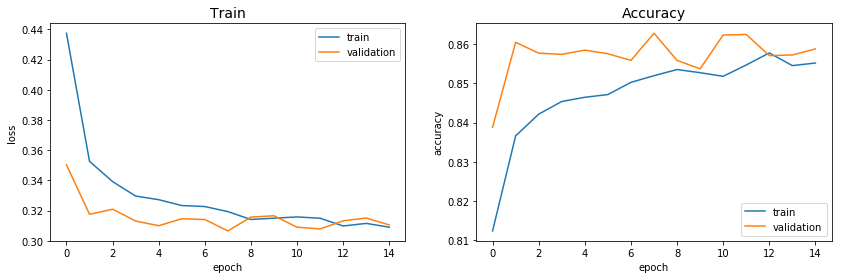

In [32]:
show_results(log)